<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/Classification_algorithms_implementation_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is designed to work out machine learning algorithms by implementing them from scratch.

The Titanic dataset was used to test the algorithms.

**Plan**:
1. Data Preprocessing
2. Logistic Regression (binary)
3. KNN
4. Decision Tree (TODO)


# The Data

In [ ]:
import pandas as pd

In [ ]:
!wget https://github.com/katearb/files/raw/main/titanic_train.csv

In [ ]:
data = pd.read_csv('/content/titanic_train.csv')

In [ ]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Preparation

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# reset index
data.index = data['PassengerId']

In [ ]:
data.drop('PassengerId', inplace=True, axis=1)

In [ ]:
# count nans
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [ ]:
# feature engineering
data['Age_known'] = ~data['Age'].isnull()
data['Cabin_known'] = ~data['Cabin'].isnull()

In [ ]:
# drop some columns
data.drop(['Cabin', 'Name', 'Ticket', 'Embarked'], inplace=True, axis=1)

In [ ]:
# map binary feature
sex_map_dict = {'male': 1, 
           'female': 0}

data['Sex'] = data['Sex'].map(sex_map_dict)

In [ ]:
# Impute Nans
data = pd.DataFrame(KNNImputer().fit_transform(data), columns=data.columns)

In [ ]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.33,
                                                    shuffle=True)

# Models

In [ ]:
from sklearn.base import BaseEstimator
import numpy as np

from sklearn.metrics import classification_report

import random
random.seed(0)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def draw_errors(errors):
  plt.clf()
  clear_output(wait=True)
  plt.ion()
  x = list(range(len(errors)))
  plt.plot(errors)
  plt.title(f'Epoch {len(x)}')
  plt.show()

## Logistic regression

Logistic regression is one of the fundamental algorithms used in machine learning. Logistic Regression predicts the probability of belonging to 0 or 1. It is based on linear equation and sigmoid.

Assumptions it requires:
1. No multicollinearity
2. No outliers

Advantages:
1. return probabilities
2. efficient and fast to train
3. Doesn't require large dataset
4. Useful for feature importance estimation
5. May be modified for multiclass task.


In [ ]:
from math import exp, sqrt

def sigmoid(z):
  return 1.0 / (1 + np.exp(-z))

class LogisticRegression(BaseEstimator):
  def __init__(self, penalty: {'l1', 'l2', 'elasticnet', None}=None,  # type of regularization
               C: float=10.0,  # inverse strength of regularization
               l1_ratio: float=0.5,  # ratio of l1 regularization
               lr: float=0.1,  # learning rate for gradient descend
               epochs: int=1,  # number of iteration through data
               threshold: float=0.5,  # threshold for making decision on predict
               batch_size: int=10):  # number of samples used for 1 gradient descend iteration
    self.penalty = penalty
    self.C = C
    self.lr = lr
    self.epochs = epochs
    self.threshold = threshold
    self.batch_size = batch_size
    self.l1_ratio = l1_ratio

  def fit(self, X: pd.DataFrame,
                y: pd.Series):
    '''
    This method updates coefficients using gradient descend.
    '''
    self.coefs = np.array([0.0 for _ in range(X.shape[1]+1)])  # init coefs

    epochs_errors = []  # list for accumulating epochs' errors
    for epoch in range(self.epochs):
      mean_error = []  # collect epoch error

      # iterate through dataset
      for start in range(0, len(X), self.batch_size): 

        # 1. get features and labels
        features = np.array(X.iloc[start:start +self.batch_size, :])
        labels = y[start:start+self.batch_size]

        # 2. make predictions of probabilities
        predictions = self.predict_proba(features)

        # 3. calculate error
        error = predictions - labels

        # 4. update coefs -- gradient descend iteration
        exit = self._update_coefs(features, error)  # gradient descend iteration

        if exit == -1:  # if gradient becomes inf
          break
        
        # 5. calculate LogLoss
        cost = self._cost_function(labels, predictions)
        mean_error.append(cost)

      else:  # if break was not triggered
        epochs_errors.append(np.mean(mean_error))  # collect epochs' errors
        draw_errors(epochs_errors)  # draw progress
        continue

      return
  

  def _cost_function(self, labels, predictions):
      '''
      LogLoss = (labels*log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
      '''

      # take the error when label = 1
      class1_cost = -labels*np.log1p(predictions)

      # take the error when label = 0
      class2_cost = (1-labels)*np.log1p(1-predictions)

      # take the sum of both costs
      cost = class1_cost + class2_cost

      # take the average cost on batch
      cost = - cost.sum() / self.batch_size

      return cost

  def _update_coefs(self, features: pd.DataFrame,
                          error: pd.Series):
    '''
    Vectorized Gradient Descent
    '''

    # 1. calculate gradient with resrect to weights
    gradient = self.C * np.dot(features.T,  error) + self._penalize()

    # 2. multiply by learning rate
    gradient *= self.lr

    # check if gradient is proper
    if np.inf in gradient:
      return -1

    # 3. take the average
    gradient /= self.batch_size

    # 4. update intercept and slope
    self.coefs[0] -= self.lr * np.mean(self.C * error + self._penalize())
    self.coefs[1:] -= gradient

  def _penalize(self):
    '''
    Regularization term estimation
    return: float
    '''

    if self.penalty is None:
      return 0.0
    
    if self.penalty == 'l1':
      return np.sum(abs(self.coefs))

    if self.penalty == 'l2':
      return np.sum(self.coefs**2)
    
    # elasticnet
    return (self.l1_ratio * np.sum(abs(self.coefs)) + \
            (1 - self.l1_ratio) * np.sum(self.coefs**2))

  def predict(self, X: pd.DataFrame):
    '''
    Make decisions based on the probabilities and the threshold
    return: np.array
    '''
    preds = np.array([])
    for row in range(len(X)):
      features = X.iloc[row, :]
      pred_proba = 1 if self.predict_proba([features])[0] > self.threshold else 0
      preds = np.append(preds,  pred_proba)
    return preds

  def predict_proba(self, X: pd.DataFrame):
    '''
    The probability estimation based on sigmoid
    return: np.array
    '''
    z = np.dot(X, self.coefs[1:]) + self.coefs[0]
    return sigmoid(z)


In [ ]:
lr = LogisticRegression(epochs=100, lr=0.00025, batch_size=5, penalty='l2', C=0.8)

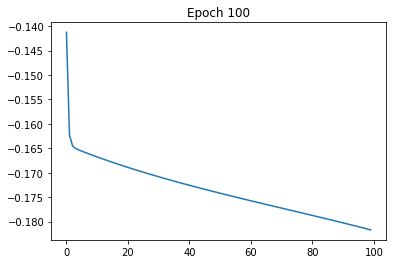

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80       182
         1.0       0.78      0.31      0.44       113

    accuracy                           0.70       295
   macro avg       0.73      0.63      0.62       295
weighted avg       0.72      0.70      0.66       295



In [ ]:
lr.coefs

array([-0.09177831, -0.1240795 , -0.25357525, -0.0222695 , -0.15844224,
       -0.02024587,  0.01990588, -0.00381722,  0.04764612])

# K-Nearest-Neighbors

KNN is a non-parametric algorithm that makes predictions based on distances from the input sample and samples in the training data. It allows to build non-linear decision boundaries.

The main hyper-parameter is k -- number of neighbors to consider while predictions making.

It is also important to scale the data as distances are calculated.

Advantages:
1. Non-linear boundary
2. Fast to train as there is no training process per se
3. Makes no assumptions on data distribution

Disadvatages:
1. Requires a lot of memory to store the data
2. Takes a lot of time to make predictions as it computes distances from the input sample to the whole training set

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
# scale
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [ ]:
class KNearestNeighbors(BaseEstimator):
  def __init__(self, k: int=3,  # number of nearest neighbors
               weights: Dict['uniform', 'distance']='uniform',  # weight function used in prediction
               p: int=2):  # minkowski metric parameter
    self.k = k
    self.weights = weights
    self.p = p

  def _predict_uniform(self, k_nearest):
    '''
    Make predictions without taking distances into consideration 
    '''
    # take classes of the nearest neigbors, count and sort them
    classes = self.labels[self.labels.index.isin(k_nearest.index)].value_counts()

    # take the most frequent one
    return classes.index[0]

  def _predict_distance(self, k_nearest):
    '''
    Make predictions based on distances to the nearest neighbors
    '''
    classes_weights = {}  # dictionary for sums of inverse distances
    for id, dist in zip(k_nearest.index, k_nearest):
      label = self.labels[id]
      # add inverse distance
      classes_weights[label] = classes_weights.get(label, 0) + 1/(dist + 0.1e5)

    # sort weights
    sorted_w = sorted([(k, v) for k, v in classes_weights.items()], 
                      key=lambda x: x[1],
                      reverse=True)
    
    # take label with the biggest weight
    return sorted_w[0][0]

  def fit(self, X, y):
    '''
    Store training set and labels
    '''
    X.index = y.index = range(len(X))

    self.X_train = X
    self.labels = y

  def predict(self, X):
    '''
    Compute distances and make predictions
    '''
    # compute distances
    distances = pd.DataFrame(distance_matrix(self.X_train, X, p=self.p), 
                             index=self.labels.index)

    predictions = np.array([])
    for sample in distances:
      k_nearest = distances[sample].sort_values()[:self.k]  # find k nearest 

      # make predictions based on the choosen method
      if self.weights == 'uniform':
        predictions = np.append(predictions, self._predict_uniform(k_nearest))
      else:
        predictions = np.append(predictions, self._predict_distance(k_nearest))
      
    return predictions

In [ ]:
knn = KNearestNeighbors(k=10, weights='distance')

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84       182
         1.0       0.80      0.59      0.68       113

    accuracy                           0.79       295
   macro avg       0.79      0.75      0.76       295
weighted avg       0.79      0.79      0.78       295

